In [10]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [199]:
dataset = pd.read_csv('company_revenue.csv')
dataset.head()

,demand,snap_CA,snap_TX,snap_WI,sell_price,week,day,dayofweek,w_y,isweekend,...,revenue_rolling_std_t4,revenue_rolling_mean_t12,revenue_rolling_skew_t4,revenue_rolling_kurt_t4,year,month,y_pred_scaled,y_scaled,version,y_pred
0,6.00000,1,1,0,2.24000,2,7,0,22013,0,...,6.56250,13.57812,0.02494,-4.56890,2013,1,10.87621,13.44000,101,10.87621
1,2.00000,0,0,1,2.24000,3,14,0,32013,0,...,5.24609,14.13281,-0.07849,-4.43211,2013,1,12.23308,4.48000,102,12.23308
2,3.00000,0,0,0,2.24000,4,21,0,42013,0,...,9.27344,13.76562,0.39515,1.40093,2013,1,11.51593,6.72000,103,11.51593
3,10.00000,0,0,0,2.24000,5,28,0,52013,0,...,10.63281,11.33594,1.18544,0.39601,2013,1,14.54913,22.40000,104,14.54913
4,10.00000,1,0,0,2.24000,6,4,0,62013,0,...,9.21094,11.52344,0.35572,1.28215,2013,2,15.27716,22.40000,105,15.27716


In [201]:
#Выбор только нужных столбцов
dataset = dataset[["demand","sell_price","lag_t1","lag_t2",
"lag_t3","lag_t4","rolling_mean_t4","rolling_std_t4","rolling_mean_t12",
"sell_price_lag_t1","sell_price_lag_t2","sell_price_lag_t3","sell_price_lag_t4",
"sell_price_rolling_mean_t4","sell_price_rolling_std_t4",
"sell_price_rolling_mean_t12","revenue"]]

In [203]:
dataset.shape

(100000, 17)

In [204]:
#Предварительный анализ
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   demand                       100000 non-null  float64
 1   sell_price                   99178 non-null   float64
 2   lag_t1                       100000 non-null  float64
 3   lag_t2                       100000 non-null  float64
 4   lag_t3                       100000 non-null  float64
 5   lag_t4                       100000 non-null  float64
 6   rolling_mean_t4              100000 non-null  float64
 7   rolling_std_t4               100000 non-null  float64
 8   rolling_mean_t12             100000 non-null  float64
 9   sell_price_lag_t1            99139 non-null   float64
 10  sell_price_lag_t2            99099 non-null   float64
 11  sell_price_lag_t3            99059 non-null   float64
 12  sell_price_lag_t4            99019 non-null   float64
 13  

In [206]:
# Вывод информации об отсутствующих значениях
dataset.isnull().sum()

demand                            0
sell_price                      822
lag_t1                            0
lag_t2                            0
lag_t3                            0
lag_t4                            0
rolling_mean_t4                   0
rolling_std_t4                    0
rolling_mean_t12                  0
sell_price_lag_t1               861
sell_price_lag_t2               901
sell_price_lag_t3               941
sell_price_lag_t4               981
sell_price_rolling_mean_t4     1101
sell_price_rolling_std_t4      1101
sell_price_rolling_mean_t12    1451
revenue                         822
dtype: int64

In [228]:
#удаление пустых значений
dataset.dropna(inplace=True)

In [230]:
dataset.isnull().sum()

demand                         0
sell_price                     0
lag_t1                         0
lag_t2                         0
lag_t3                         0
lag_t4                         0
rolling_mean_t4                0
rolling_std_t4                 0
rolling_mean_t12               0
sell_price_lag_t1              0
sell_price_lag_t2              0
sell_price_lag_t3              0
sell_price_lag_t4              0
sell_price_rolling_mean_t4     0
sell_price_rolling_std_t4      0
sell_price_rolling_mean_t12    0
revenue                        0
dtype: int64

In [232]:
#Предварительный анализ
dataset.describe()

,demand,sell_price,lag_t1,lag_t2,lag_t3,lag_t4,rolling_mean_t4,rolling_std_t4,rolling_mean_t12,sell_price_lag_t1,sell_price_lag_t2,sell_price_lag_t3,sell_price_lag_t4,sell_price_rolling_mean_t4,sell_price_rolling_std_t4,sell_price_rolling_mean_t12,revenue
count,98549.00000,98549.00000,98549.00000,98549.00000,98549.00000,98549.00000,98549.00000,98549.00000,98549.00000,98549.00000,98549.00000,98549.00000,98549.00000,98549.00000,98549.00000,98549.00000,98549.00000
mean,7.13273,4.24314,7.11132,7.08821,7.07799,7.06863,7.05176,3.04978,6.99628,4.24275,4.24252,4.24230,4.24206,4.24166,0.01400,4.24002,32.06299
std,15.10887,1.95705,15.03544,14.95962,14.93021,14.89245,14.04543,4.40035,13.28355,1.95723,1.95759,1.95797,1.95833,1.95749,0.08180,1.95696,91.66774
min,0.00000,0.35000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.35010,0.35010,0.35010,0.35010,0.50000,0.00000,0.50000,0.00000
25%,0.00000,2.48000,0.00000,0.00000,0.00000,0.00000,1.00000,0.95752,1.41699,2.48047,2.48047,2.48047,2.48047,2.48047,0.00000,2.48047,0.00000
50%,3.00000,3.88000,3.00000,3.00000,3.00000,3.00000,3.50000,2.06250,3.50000,3.88086,3.88086,3.88086,3.88086,3.88086,0.00000,3.88086,10.94000
75%,8.00000,5.56000,8.00000,8.00000,8.00000,8.00000,7.75000,3.78516,7.58203,5.55859,5.55859,5.55859,5.55859,5.56641,0.00000,5.56250,29.77000
max,439.00000,12.98000,439.00000,439.00000,439.00000,439.00000,412.50000,148.00000,385.25000,12.97656,12.97656,12.97656,12.97656,12.97656,3.22852,11.84375,3174.00000


-----------------------------------------------------------------------------------------------------------------------------
**Описание дата сета:** \
demand: спрос на товары\
sell_price: средняя цена продажи товаров\
lag_t1: спрос на товаров в предыдущий момент времени (t-1)\
lag_t2: спрос на товаров в момент времени еще более ранний, чем lag_t1 (t-2)\
lag_t3: спрос на товаров в момент времени еще более ранний, чем lag_t2 (t-3)\
lag_t4: спрос на товаров в момент времени еще более ранний, чем lag_t3 (t-4)\
rolling_mean_t4: скользящее среднее значение спроса на товары за последние 4 момента времени\
rolling_std_t4: скользящее стандартное отклонение спроса на товары за последние 4 момента времени\
rolling_mean_t12: скользящее среднее значение спроса на товары за последние 12 моментов времени\
sell_price_lag_t1: средняя цена продажи товаров в предыдущий момент времени (t-1)\
sell_price_lag_t2: средняя цена продажи товаров в момент времени еще более ранний, чем sell_price_lag_t1 (t-2)\
sell_price_lag_t3: средняя цена продажи товаров в момент времени еще более ранний, чем sell_price_lag_t2 (t-3)\
sell_price_lag_t4: средняя цена продажи товаров в момент времени еще более ранний, чем sell_price_lag_t3 (t-4)\
sell_price_rolling_mean_t4: скользящее среднее значение цены продажи товаров за последние 4 момента времени\
sell_price_rolling_std_t4: скользящее стандартное отклонение цены продажи товаров за последние 4 момента времени\
sell_price_rolling_mean_t12: скользящее среднее значение цены продажи товаров за последние 12 моментов времени\
revenue: выручка

-----------------------------------------------------------------------------------------------------------------------------

In [233]:
dataset.corr()

,demand,sell_price,lag_t1,lag_t2,lag_t3,lag_t4,rolling_mean_t4,rolling_std_t4,rolling_mean_t12,sell_price_lag_t1,sell_price_lag_t2,sell_price_lag_t3,sell_price_lag_t4,sell_price_rolling_mean_t4,sell_price_rolling_std_t4,sell_price_rolling_mean_t12,revenue
demand,1.00000,0.06081,0.89015,0.86963,0.85220,0.83927,0.86757,0.53511,0.85525,0.06068,0.06039,0.05996,0.05947,0.05900,0.00011,0.05827,0.94942
sell_price,0.06081,1.00000,0.05987,0.05946,0.05847,0.05751,0.05891,-0.02059,0.05659,0.99897,0.99777,0.99695,0.99632,0.99619,0.04162,0.99524,0.19135
lag_t1,0.89015,0.05987,1.00000,0.88912,0.86728,0.84943,0.87674,0.54391,0.86355,0.05988,0.05972,0.05941,0.05898,0.05838,-0.00032,0.05751,0.86833
lag_t2,0.86963,0.05946,0.88912,1.00000,0.88691,0.86506,0.88797,0.55608,0.87249,0.05926,0.05926,0.05910,0.05879,0.05815,0.00032,0.05713,0.85464
lag_t3,0.85220,0.05847,0.86728,0.88691,1.00000,0.88561,0.90260,0.57662,0.88262,0.05840,0.05818,0.05818,0.05801,0.05747,0.00024,0.05631,0.84115
lag_t4,0.83927,0.05751,0.84943,0.86506,0.88561,1.00000,0.94519,0.63374,0.90298,0.05749,0.05740,0.05718,0.05717,0.05682,-0.00187,0.05557,0.83147
rolling_mean_t4,0.86757,0.05891,0.87674,0.88797,0.90260,0.94519,1.00000,0.67891,0.96393,0.05897,0.05897,0.05888,0.05877,0.05855,-0.01100,0.05734,0.86252
rolling_std_t4,0.53511,-0.02059,0.54391,0.55608,0.57662,0.63374,0.67891,1.00000,0.62325,-0.02041,-0.02035,-0.02043,-0.02066,-0.02108,0.02460,-0.02259,0.48153
rolling_mean_t12,0.85525,0.05659,0.86355,0.87249,0.88262,0.90298,0.96393,0.62325,1.00000,0.05670,0.05678,0.05683,0.05687,0.05688,-0.01466,0.05622,0.85777
sell_price_lag_t1,0.06068,0.99897,0.05988,0.05926,0.05840,0.05749,0.05897,-0.02041,0.05670,1.00000,0.99896,0.99774,0.99692,0.99671,0.04111,0.99569,0.19118


## Разделение данных на обучающую, тестовую и валидационную выборки

In [234]:
# Определяем кастомный датасет
class MyDataset(Dataset):
    def __init__(self, data_X, data_y):
        self.data_X = data_X
        self.data_y = data_y
    def __getitem__(self, idx):
        x = self.data_X[idx]
        y = self.data_y[idx]
        return x,y
    def __len__(self):
        return len(self.data_X)
# Разделите набор данных на обучающую, тестовую и валидационную выборки
train_val_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

# Преобразуйте каждый из них в тензоры PyTorch.
train_x = torch.tensor(train_df.drop(['revenue'], axis=1).values).float()
train_y = torch.tensor(train_df['revenue'].values.reshape(-1,1)).float()
test_x = torch.tensor(test_df.drop(['revenue'], axis=1).values).float()
test_y = torch.tensor(test_df['revenue'].values.reshape(-1,1)).float()
val_x = torch.tensor(val_df.drop(['revenue'], axis=1).values).float()
val_y = torch.tensor(val_df['revenue'].values.reshape(-1,1)).float()

# Создайте наборы данных TensorDataset для каждого из наборов.
train_dataset = MyDataset(train_x, train_y)
test_dataset = MyDataset(test_x, test_y)
val_dataset = MyDataset(val_x, val_y)

# Создайте DataLoader для каждого набора данных.
batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## Создание моделей

1 модель

In [212]:
class MLP_1(nn.Module):
    def __init__(self,hidden_size_1,hidden_size_2):
        super(MLP_1, self).__init__()
        self.fc1 = nn.Linear(in_features=16, out_features=hidden_size_1)
        self.fc2 = nn.Linear(in_features=hidden_size_1, out_features=hidden_size_2)
        self.fc3 = nn.Linear(in_features=hidden_size_2, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [221]:
model_1 = MLP_1(hidden_size_1=32,hidden_size_2=16)
# Определяем функцию потерь
criterion = nn.MSELoss()
# Определяем оптимизатор
optimizer = optim.Adam(model_1.parameters(), lr=0.001, weight_decay=0.001)
# Определяем количество эпох
n_epochs = 30

In [222]:
# Цикл обучения
sp_running_loss = []
sp_val_loss = []
for epoch in range(n_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # Получаем входные данные и метки
        inputs, labels = data
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Прямой проход
        outputs = model_1(inputs)
        # Вычисляем функцию потерь
        loss = criterion(outputs, labels)
        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()
        # Выводим статистику обучения
        running_loss += loss.item() 
    val_loss = 0.0
    for i, data in enumerate(val_loader):
        inputs, labels = data
        outputs = model_1(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
    sp_running_loss.append(running_loss/ len(train_loader))
    sp_val_loss.append(val_loss/ len(val_loader))
    print('Epoch %d - Train Loss: %.3f - Val Loss: %.3f' % (epoch+1, running_loss / len(train_loader), val_loss / len(val_loader)))

test_loss = 0.0
for i, data in enumerate(test_loader):
    inputs, labels = data
    outputs = model_1(inputs)
    loss = criterion(outputs, labels)
    test_loss += loss.item()
print('Test Loss: %.3f' % (test_loss/len(test_loader)))

print('Обучение закончено')

Epoch 1 - Train Loss: 2090.019 - Val Loss: 909.049
Epoch 2 - Train Loss: 666.278 - Val Loss: 624.764
Epoch 3 - Train Loss: 520.924 - Val Loss: 561.098
Epoch 4 - Train Loss: 463.467 - Val Loss: 495.515
Epoch 5 - Train Loss: 424.764 - Val Loss: 461.850
Epoch 6 - Train Loss: 394.778 - Val Loss: 422.893
Epoch 7 - Train Loss: 375.835 - Val Loss: 396.004
Epoch 8 - Train Loss: 342.631 - Val Loss: 396.207
Epoch 9 - Train Loss: 316.905 - Val Loss: 347.412
Epoch 10 - Train Loss: 285.422 - Val Loss: 354.069
Epoch 11 - Train Loss: 270.922 - Val Loss: 280.287
Epoch 12 - Train Loss: 252.144 - Val Loss: 252.440
Epoch 13 - Train Loss: 215.550 - Val Loss: 227.332
Epoch 14 - Train Loss: 196.285 - Val Loss: 221.909
Epoch 15 - Train Loss: 208.467 - Val Loss: 177.672
Epoch 16 - Train Loss: 152.570 - Val Loss: 161.401
Epoch 17 - Train Loss: 133.044 - Val Loss: 136.276
Epoch 18 - Train Loss: 156.500 - Val Loss: 139.047
Epoch 19 - Train Loss: 108.337 - Val Loss: 111.827
Epoch 20 - Train Loss: 117.255 - Val Lo

In [223]:
# Оценка качества модели на тестовой выборке
model_1.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model_1(inputs)
        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print("R2:",r2)
print("MSE",mse)
print("MAE",mae)

R2: 0.9945371259755824
MSE 50.639492
MAE 2.4976718


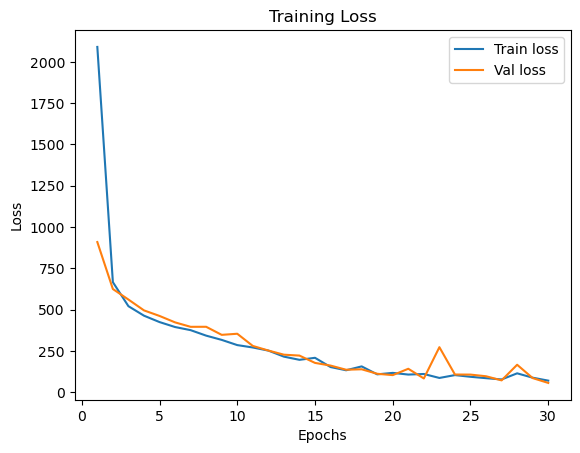

In [224]:
epochs = range(1, n_epochs+1)
# создание объекта рисунка и оси
fig, ax = plt.subplots()

# построение графиков на оси
ax.plot(epochs, sp_running_loss, label='Train loss')
ax.plot(epochs, sp_val_loss, label='Val loss')

# установка заголовка и меток осей
ax.set_title('Training Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

# добавление легенды
ax.legend()

# отображение графика
plt.show()

2 модель

In [247]:
class MLP_2(nn.Module):
    def __init__(self):
        super(MLP_2, self).__init__()
        self.fc1 = nn.Linear(in_features=16, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=16)
        self.fc3 = nn.Linear(in_features=16, out_features=8)
        self.fc4 = nn.Linear(in_features=8, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [259]:
model_2 = MLP_2()
# Определяем функцию потерь
criterion_2 = nn.MSELoss()
# Определяем оптимизатор
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001, weight_decay=0.001)
# Определяем количество эпох
n_epochs_2 = 30

In [256]:
# Цикл обучения
sp_running_loss_2 = []
sp_val_loss_2 = []
for epoch in range(n_epochs_2):
    running_loss_2 = 0.0
    for i_2, data_2 in enumerate(train_loader):
        # Получаем входные данные и метки
        inputs_2, labels_2 = data_2
        # Обнуляем градиенты
        optimizer_2.zero_grad()
        # Прямой проход
        outputs_2 = model_2(inputs_2)
        # Вычисляем функцию потерь
        loss_2 = criterion_2(outputs_2, labels_2)
        # Обратный проход и оптимизация
        loss_2.backward()
        optimizer_2.step()
        # Выводим статистику обучения
        running_loss_2 += loss_2.item() 
    val_loss_2 = 0.0
    for i_2, data_2 in enumerate(val_loader):
        inputs_2, labels_2 = data_2
        outputs_2 = model_2(inputs_2)
        loss_2 = criterion_2(outputs_2, labels_2)
        val_loss_2 += loss_2.item()
    sp_running_loss_2.append(running_loss_2/ len(train_loader))
    sp_val_loss_2.append(val_loss_2/ len(val_loader))
    print('Epoch %d - Train Loss: %.3f - Val Loss: %.3f' % (epoch+1, running_loss_2 / len(train_loader), val_loss_2 / len(val_loader)))

test_loss_2 = 0.0
for i_2, data_2 in enumerate(test_loader):
    inputs_2, labels_2 = data_2
    outputs_2 = model_2(inputs_2)
    loss_2 = criterion_2(outputs_2, labels_2)
    test_loss_2 += loss_2.item()
print('Test Loss: %.3f' % (test_loss_2/len(test_loader)))

print('Обучение закончено')

Epoch 1 - Train Loss: 1554.153 - Val Loss: 704.989
Epoch 2 - Train Loss: 540.897 - Val Loss: 533.680
Epoch 3 - Train Loss: 460.074 - Val Loss: 487.401
Epoch 4 - Train Loss: 410.268 - Val Loss: 509.607
Epoch 5 - Train Loss: 360.906 - Val Loss: 375.023
Epoch 6 - Train Loss: 328.577 - Val Loss: 336.455
Epoch 7 - Train Loss: 321.778 - Val Loss: 393.780
Epoch 8 - Train Loss: 266.531 - Val Loss: 281.999
Epoch 9 - Train Loss: 230.235 - Val Loss: 223.090
Epoch 10 - Train Loss: 202.212 - Val Loss: 189.083
Epoch 11 - Train Loss: 171.076 - Val Loss: 212.402
Epoch 12 - Train Loss: 172.052 - Val Loss: 166.510
Epoch 13 - Train Loss: 122.707 - Val Loss: 128.605
Epoch 14 - Train Loss: 118.934 - Val Loss: 243.631
Epoch 15 - Train Loss: 127.338 - Val Loss: 103.303
Epoch 16 - Train Loss: 116.347 - Val Loss: 109.785
Epoch 17 - Train Loss: 135.213 - Val Loss: 86.872
Epoch 18 - Train Loss: 96.212 - Val Loss: 167.588
Epoch 19 - Train Loss: 101.520 - Val Loss: 79.230
Epoch 20 - Train Loss: 131.995 - Val Loss:

In [257]:
# Оценка качества модели на тестовой выборке
model_2.eval()
y_pred_2 = []
y_true_2 = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model_2(inputs)
        y_pred_2.extend(outputs.cpu().numpy())
        y_true_2.extend(labels.cpu().numpy())
r2_2 = r2_score(y_true_2, y_pred_2)
mse_2 = mean_squared_error(y_true_2, y_pred_2)
mae_2 = mean_absolute_error(y_true_2, y_pred_2)
print("R2:",r2_2)
print("MSE",mse_2)
print("MAE",mae_2)

R2: 0.99366851883533
MSE 58.69126
MAE 2.2918303


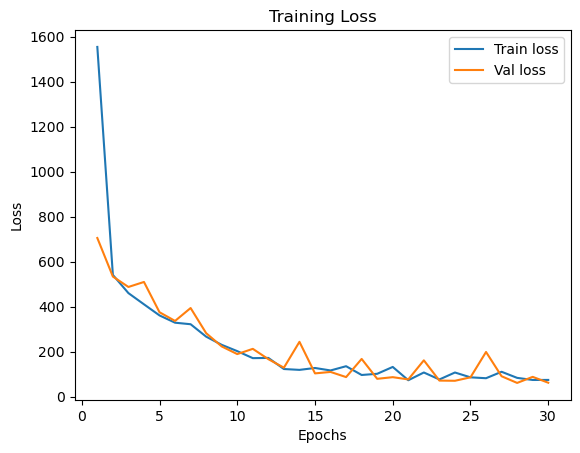

In [258]:
epochs = range(1, n_epochs+1)
# создание объекта рисунка и оси
fig, ax = plt.subplots()

# построение графиков на оси
ax.plot(epochs, sp_running_loss_2, label='Train loss')
ax.plot(epochs, sp_val_loss_2, label='Val loss')

# установка заголовка и меток осей
ax.set_title('Training Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

# добавление легенды
ax.legend()

# отображение графика
plt.show()

3 модель

In [263]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=64*4, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=1)

    def forward(self, x):
        x = x.view(-1, 1, 16)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64*4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [284]:
model_3 = MyCNN()
# Определяем функцию потерь
criterion_3 = nn.MSELoss()
# Определяем оптимизатор
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.001, weight_decay=0.01)
# Определяем количество эпох
n_epochs_3 = 30

In [285]:
# Цикл обучения
sp_running_loss_3 = []
sp_val_loss_3 = []
for epoch in range(n_epochs_3):
    running_loss_3 = 0.0
    for i_3, data_3 in enumerate(train_loader):
        # Получаем входные данные и метки
        inputs_3, labels_3 = data_3
        # Обнуляем градиенты
        optimizer_3.zero_grad()
        # Прямой проход
        outputs_3 = model_3(inputs_3)
        # Вычисляем функцию потерь
        loss_3 = criterion_3(outputs_3, labels_3)
        # Обратный проход и оптимизация
        loss_3.backward()
        optimizer_3.step()
        # Выводим статистику обучения
        running_loss_3 += loss_3.item() 
    val_loss_3 = 0.0
    for i_3, data_3 in enumerate(val_loader):
        inputs_3, labels_3 = data_3
        outputs_3 = model_3(inputs_3)
        loss_3 = criterion_3(outputs_3, labels_3)
        val_loss_3 += loss_3.item()
    sp_running_loss_3.append(running_loss_3/ len(train_loader))
    sp_val_loss_3.append(val_loss_3/ len(val_loader))
    print('Epoch %d - Train Loss: %.3f - Val Loss: %.3f' % (epoch+1, running_loss_3 / len(train_loader), val_loss_3 / len(val_loader)))

test_loss_3 = 0.0
for i_3, data_3 in enumerate(test_loader):
    inputs_3, labels_3 = data_3
    outputs_3 = model_3(inputs_3)
    loss_3 = criterion_3(outputs_3, labels_3)
    test_loss_3 += loss_3.item()
print('Test Loss: %.3f' % (test_loss_3/len(test_loader)))

print('Обучение закончено')

Epoch 1 - Train Loss: 859.586 - Val Loss: 319.837
Epoch 2 - Train Loss: 217.453 - Val Loss: 274.417
Epoch 3 - Train Loss: 142.757 - Val Loss: 88.576
Epoch 4 - Train Loss: 99.426 - Val Loss: 71.771
Epoch 5 - Train Loss: 105.758 - Val Loss: 65.217
Epoch 6 - Train Loss: 95.203 - Val Loss: 49.158
Epoch 7 - Train Loss: 79.692 - Val Loss: 62.078
Epoch 8 - Train Loss: 105.705 - Val Loss: 77.991
Epoch 9 - Train Loss: 38.233 - Val Loss: 25.349
Epoch 10 - Train Loss: 96.586 - Val Loss: 24.931
Epoch 11 - Train Loss: 46.784 - Val Loss: 59.617
Epoch 12 - Train Loss: 52.247 - Val Loss: 45.016
Epoch 13 - Train Loss: 38.033 - Val Loss: 15.720
Epoch 14 - Train Loss: 51.612 - Val Loss: 53.470
Epoch 15 - Train Loss: 41.048 - Val Loss: 20.160
Epoch 16 - Train Loss: 19.868 - Val Loss: 17.900
Epoch 17 - Train Loss: 35.649 - Val Loss: 14.810
Epoch 18 - Train Loss: 32.327 - Val Loss: 12.738
Epoch 19 - Train Loss: 29.637 - Val Loss: 13.569
Epoch 20 - Train Loss: 42.344 - Val Loss: 17.875
Epoch 21 - Train Loss:

In [291]:
# Оценка качества модели на тестовой выборке
model_3.eval()
y_pred_3 = []
y_true_3 = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model_3(inputs)
        y_pred_3.extend(outputs.cpu().numpy())
        y_true_3.extend(labels.cpu().numpy())
r2_3 = r2_score(y_true_3, y_pred_3)
mse_3 = mean_squared_error(y_true_3, y_pred_3)
mae_3 = mean_absolute_error(y_true_3, y_pred_3)
print("R2:",r2_3)
print("MSE",mse_3)
print("MAE",mae_3)

R2: 0.9985507929440378
MSE 13.433791
MAE 1.7121409


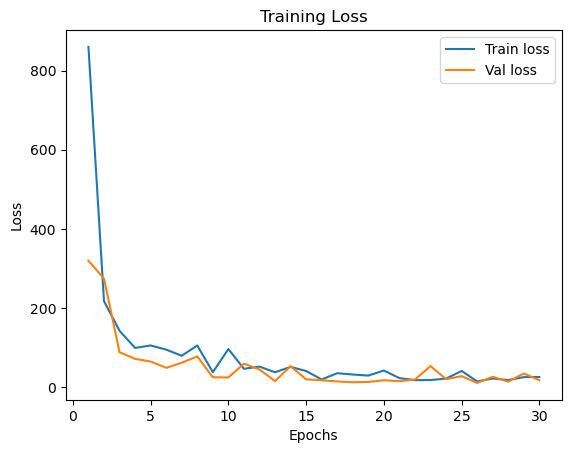

In [295]:
epochs = range(1, n_epochs_3+1)
# создание объекта рисунка и оси
fig, ax = plt.subplots()

# построение графиков на оси
ax.plot(epochs, sp_running_loss_3, label='Train loss')
ax.plot(epochs, sp_val_loss_3, label='Val loss')

# установка заголовка и меток осей
ax.set_title('Training Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

# добавление легенды
ax.legend()

# отображение графика
plt.show()

4 модель

In [311]:
class MyDNN(nn.Module):
    def __init__(self):
        super(MyDNN, self).__init__()
        self.fc1 = nn.Linear(16, 32)
        self.sig1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 64)
        self.sig2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.sig3 = nn.ReLU()
        self.fc4 = nn.Linear(32, 16)
        self.sig4 = nn.ReLU()
        self.fc5 = nn.Linear(16, 8)
        self.sig5 = nn.ReLU()
        self.fc6 = nn.Linear(8, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.sig1(out)
        out = self.fc2(out)
        out = self.sig2(out)
        out = self.fc3(out)
        out = self.sig3(out)
        out = self.fc4(out)
        out = self.sig4(out)
        out = self.fc5(out)
        out = self.sig5(out)
        out = self.fc6(out)
        return out


In [314]:
model_4 = MyDNN()
# Определяем функцию потерь
criterion_4 = nn.MSELoss()
# Определяем оптимизатор
optimizer_4 = optim.Adam(model_4.parameters(), lr=0.001, weight_decay=0.001)
# Определяем количество эпох
n_epochs_4 = 30

In [315]:
# Цикл обучения
sp_running_loss_4 = []
sp_val_loss_4 = []
for epoch in range(n_epochs_4):
    running_loss_4 = 0.0
    for i_4, data_4 in enumerate(train_loader):
        # Получаем входные данные и метки
        inputs_4, labels_4 = data_4
        # Обнуляем градиенты
        optimizer_4.zero_grad()
        # Прямой проход
        outputs_4 = model_4(inputs_4)
        # Вычисляем функцию потерь
        loss_4 = criterion_4(outputs_4, labels_4)
        # Обратный проход и оптимизация
        loss_4.backward()
        optimizer_4.step()
        # Выводим статистику обучения
        running_loss_4 += loss_4.item() 
    val_loss_4 = 0.0
    for i_4, data_4 in enumerate(val_loader):
        inputs_4, labels_4 = data_4
        outputs_4 = model_4(inputs_4)
        loss_4 = criterion_4(outputs_4, labels_4)
        val_loss_4 += loss_4.item()
    sp_running_loss_4.append(running_loss_4/ len(train_loader))
    sp_val_loss_4.append(val_loss_4/ len(val_loader))
    print('Epoch %d - Train Loss: %.3f - Val Loss: %.3f' % (epoch+1, running_loss_4 / len(train_loader), val_loss_4 / len(val_loader)))

test_loss_4 = 0.0
for i_4, data_4 in enumerate(test_loader):
    inputs_4, labels_4 = data_4
    outputs_4 = model_4(inputs_4)
    loss_4 = criterion_4(outputs_4, labels_4)
    test_loss_4 += loss_4.item()
print('Test Loss: %.3f' % (test_loss_4/len(test_loader)))

print('Обучение закончено')

Epoch 1 - Train Loss: 1414.943 - Val Loss: 564.901
Epoch 2 - Train Loss: 498.006 - Val Loss: 474.661
Epoch 3 - Train Loss: 426.792 - Val Loss: 372.764
Epoch 4 - Train Loss: 379.990 - Val Loss: 744.189
Epoch 5 - Train Loss: 322.969 - Val Loss: 281.093
Epoch 6 - Train Loss: 279.861 - Val Loss: 236.487
Epoch 7 - Train Loss: 231.521 - Val Loss: 253.665
Epoch 8 - Train Loss: 277.142 - Val Loss: 140.581
Epoch 9 - Train Loss: 200.553 - Val Loss: 174.209
Epoch 10 - Train Loss: 159.551 - Val Loss: 502.372
Epoch 11 - Train Loss: 221.649 - Val Loss: 123.407
Epoch 12 - Train Loss: 167.091 - Val Loss: 103.996
Epoch 13 - Train Loss: 133.285 - Val Loss: 131.717
Epoch 14 - Train Loss: 152.569 - Val Loss: 124.851
Epoch 15 - Train Loss: 138.782 - Val Loss: 83.410
Epoch 16 - Train Loss: 88.687 - Val Loss: 71.715
Epoch 17 - Train Loss: 122.240 - Val Loss: 70.780
Epoch 18 - Train Loss: 103.976 - Val Loss: 72.356
Epoch 19 - Train Loss: 132.299 - Val Loss: 71.119
Epoch 20 - Train Loss: 80.637 - Val Loss: 63.

In [316]:
# Оценка качества модели на тестовой выборке
model_4.eval()
y_pred_4 = []
y_true_4 = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model_4(inputs)
        y_pred_4.extend(outputs.cpu().numpy())
        y_true_4.extend(labels.cpu().numpy())
r2_4 = r2_score(y_true_4, y_pred_4)
mse_4 = mean_squared_error(y_true_4, y_pred_4)
mae_4 = mean_absolute_error(y_true_4, y_pred_4)
print("R2:",r2_4)
print("MSE",mse_4)
print("MAE",mae_4)

R2: 0.9952177030333903
MSE 44.330715
MAE 1.6258476


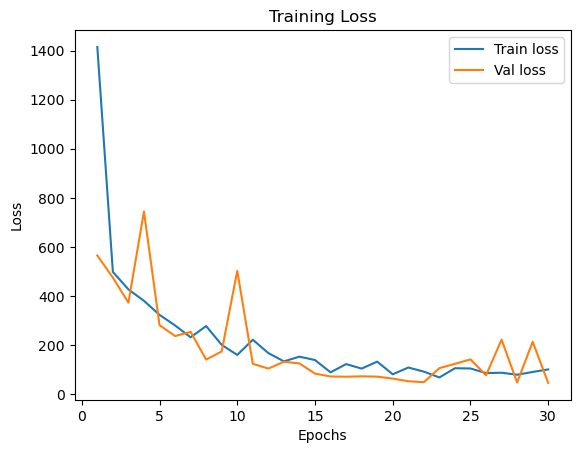

In [317]:
epochs = range(1, n_epochs_4+1)
# создание объекта рисунка и оси
fig, ax = plt.subplots()

# построение графиков на оси
ax.plot(epochs, sp_running_loss_4, label='Train loss')
ax.plot(epochs, sp_val_loss_4, label='Val loss')

# установка заголовка и меток осей
ax.set_title('Training Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

# добавление легенды
ax.legend()

# отображение графика
plt.show()

In [338]:
labels = ['1 модель', '2 модель', '3 модель', '4 модель']
r_2_values = [r2,r2_2,r2_3,r2_4]
mse_values = [mse,mse_2,mse_3,mse_4]
mae_values = [mae,mae_2,mae_3,mae_4]

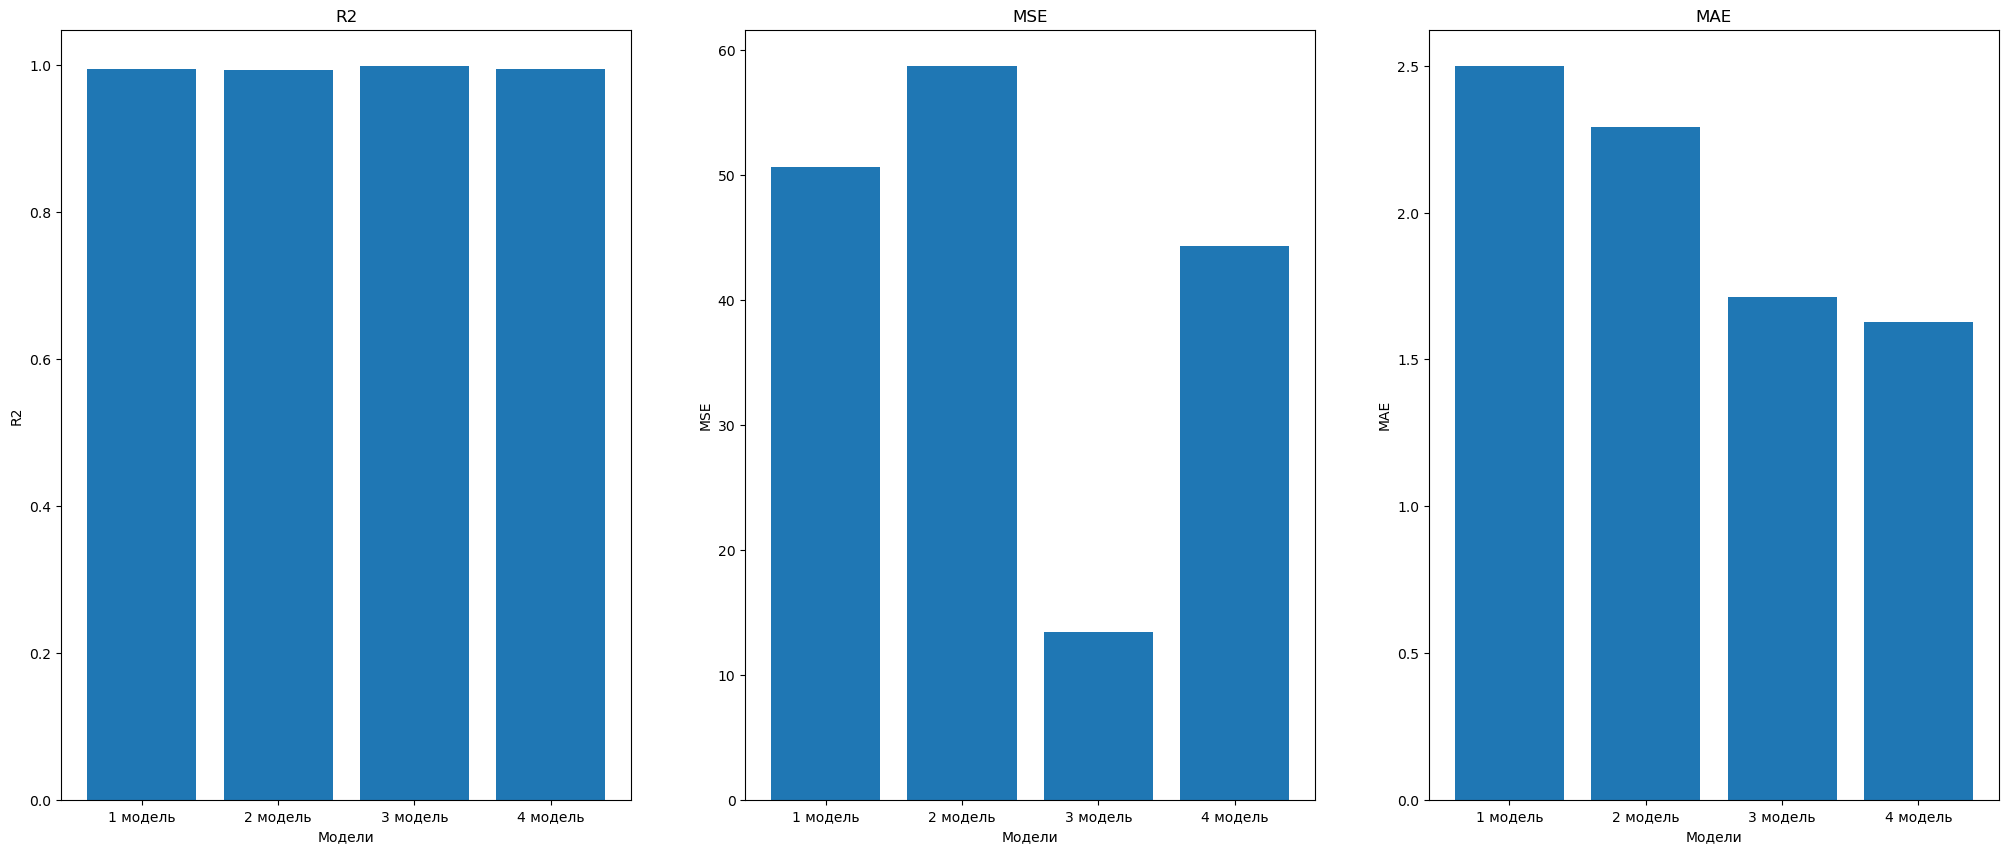

In [339]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(25, 10))

# Первый график
axs[0].bar(labels, r_2_values)
axs[0].set_title('R2')
axs[0].set_xlabel('Модели')
axs[0].set_ylabel('R2')
#Втрой график
axs[1].bar(labels, mse_values)
axs[1].set_title('MSE')
axs[1].set_xlabel('Модели')
axs[1].set_ylabel('MSE')
#Третий график
axs[2].bar(labels, mae_values)
axs[2].set_title('MAE')
axs[2].set_xlabel('Модели')
axs[2].set_ylabel('MAE')


plt.show()

In [345]:
from prettytable import PrettyTable

# Создание объекта таблицы
table = PrettyTable()

# Добавление заголовков столбцов
table.field_names = ["Модели", "R2","MSE","MAE"]

# Добавление данных
table.add_row(["Модель 1", r_2_values[0],mse_values[0],mae_values[0]])
table.add_row(["Модель 2",r_2_values[1],mse_values[1],mae_values[1]])
table.add_row(["Модель 3", r_2_values[2],mse_values[2],mae_values[2]])
table.add_row(["Модель 4", r_2_values[3],mse_values[3],mae_values[3]])

# Вывод таблицы
print(table)

+----------+--------------------+-----------+-----------+
|  Модели  |         R2         |    MSE    |    MAE    |
+----------+--------------------+-----------+-----------+
| Модель 1 | 0.9945371259755824 | 50.639492 | 2.4976718 |
| Модель 2 |  0.99366851883533  |  58.69126 | 2.2918303 |
| Модель 3 | 0.9985507929440378 | 13.433791 | 1.7121409 |
| Модель 4 | 0.9952177030333903 | 44.330715 | 1.6258476 |
+----------+--------------------+-----------+-----------+
